#### Import Helper Modules 

In [178]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [179]:
from datasist.structdata import detect_outliers
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder , OneHotEncoder , RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error , r2_score
from geopy.geocoders import Nominatim
import joblib

In [180]:
warnings.filterwarnings('ignore')

In [181]:
sns.set_theme(context = 'notebook' , style = 'darkgrid' , palette = 'mako' 
              , font_scale = 1.1 , rc = {'figure.figsize' : (8 , 4)})

In [182]:
%matplotlib inline

###### Read Dataset 

In [183]:
df = pd.read_csv('dataset.csv')
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [184]:
# rename columns to be easy to use 
col = ['Posted_By', 'Under_Construction', 'approved', 'Number_of_Rooms', 'Property_type',
       'House_areaSQF', 'Ready_to_move', 'Resale', 'Address', 'Longitude',
       'Latitude', 'Price']

In [185]:
df.columns = col

###### get data info to explore our dataset

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Posted_By           29451 non-null  object 
 1   Under_Construction  29451 non-null  int64  
 2   approved            29451 non-null  int64  
 3   Number_of_Rooms     29451 non-null  int64  
 4   Property_type       29451 non-null  object 
 5   House_areaSQF       29451 non-null  float64
 6   Ready_to_move       29451 non-null  int64  
 7   Resale              29451 non-null  int64  
 8   Address             29451 non-null  object 
 9   Longitude           29451 non-null  float64
 10  Latitude            29451 non-null  float64
 11  Price               29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


###### Remove duplicates 

In [187]:
df.duplicated().sum()

401

In [188]:
df.drop_duplicates(inplace = True , ignore_index = True)

In [189]:
df.index

RangeIndex(start=0, stop=29050, step=1)

###### Check missing records 

In [190]:
df.isnull().mean()*100

Posted_By             0.0
Under_Construction    0.0
approved              0.0
Number_of_Rooms       0.0
Property_type         0.0
House_areaSQF         0.0
Ready_to_move         0.0
Resale                0.0
Address               0.0
Longitude             0.0
Latitude              0.0
Price                 0.0
dtype: float64

###### after run anthor notebook on (Longitude , Latitude) to get any info return with more than 80% nan

In [191]:
# drop this 2 columns no benefit from them 
df.drop(['Longitude' , 'Latitude'] , axis = 1 , inplace = True )

In [192]:
df.head(3)

,Posted_By,Under_Construction,approved,Number_of_Rooms,Property_type,House_areaSQF,Ready_to_move,Resale,Address,Price
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",43.0


#### Explore our categorical feature and see the distribution of each one 

<AxesSubplot:xlabel='Resale', ylabel='count'>

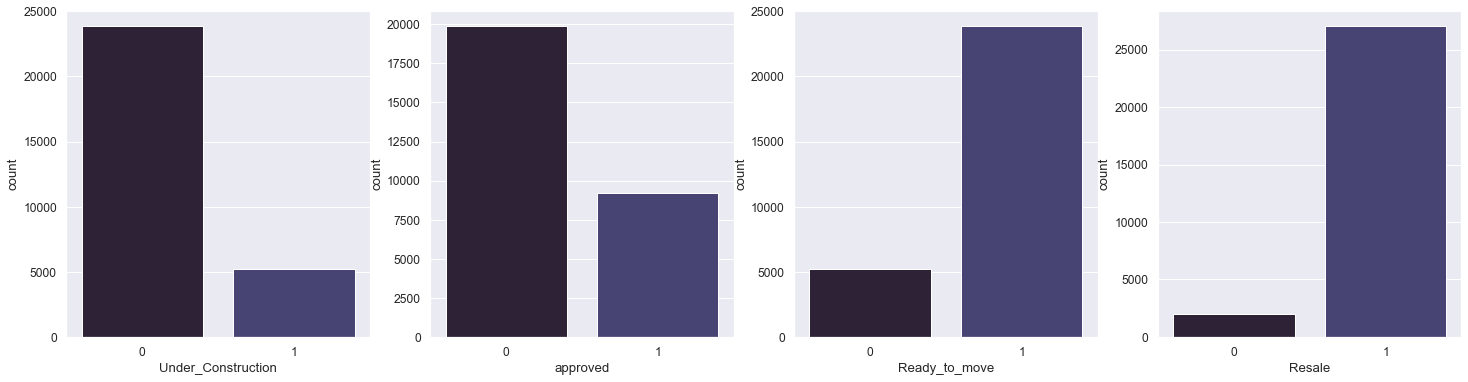

In [193]:
fig, axis = plt.subplots(nrows = 1, ncols = 4, figsize = (25,6))
sns.countplot(df['Under_Construction'] , ax = axis[0])
sns.countplot(df['approved'] , ax = axis[1])
sns.countplot(df['Ready_to_move'] , ax = axis[2])
sns.countplot(df['Resale'] , ax = axis[3])

<AxesSubplot:xlabel='Property_type', ylabel='count'>

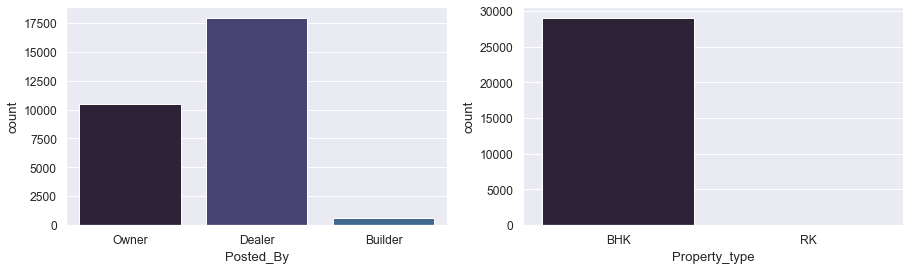

In [194]:
fig , axis = plt.subplots(ncols = 2 , nrows = 1 , figsize = (15 , 4))
sns.countplot(df['Posted_By'] , ax = axis[0])
sns.countplot(df['Property_type'] , ax = axis[1])

#### Check distribution & outliers or abnormal values for area

<AxesSubplot:xlabel='House_areaSQF', ylabel='Density'>

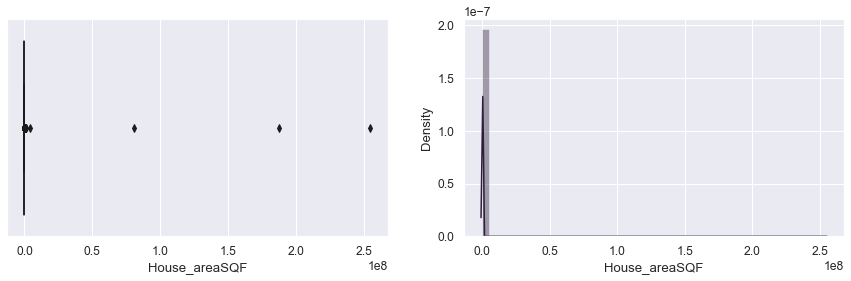

In [195]:
fig , axis = plt.subplots(ncols = 2 , nrows = 1 , figsize = (15 , 4))
sns.boxplot(df['House_areaSQF'] , ax = axis[0])
sns.distplot(df['House_areaSQF'] , ax = axis[1])

###### High area with small number of rooms and price !!!

In [196]:
df[df['House_areaSQF'] > 0.4*1e8]

,Posted_By,Under_Construction,approved,Number_of_Rooms,Property_type,House_areaSQF,Ready_to_move,Resale,Address,Price
10694,Owner,0,0,3,BHK,2.545455e+08,1,1,"Malur,Bangalore",28000.0
11178,Dealer,0,0,3,BHK,1.875000e+08,1,1,"R.T. Nagar,Bangalore",30000.0
15601,Owner,0,0,2,BHK,8.064516e+07,1,1,"Lakkasandra,Bangalore",25000.0


In [197]:
# drop this samples 
df.drop([10694 , 11178 , 15601] , axis = 0 , inplace = True)

<AxesSubplot:xlabel='House_areaSQF', ylabel='Density'>

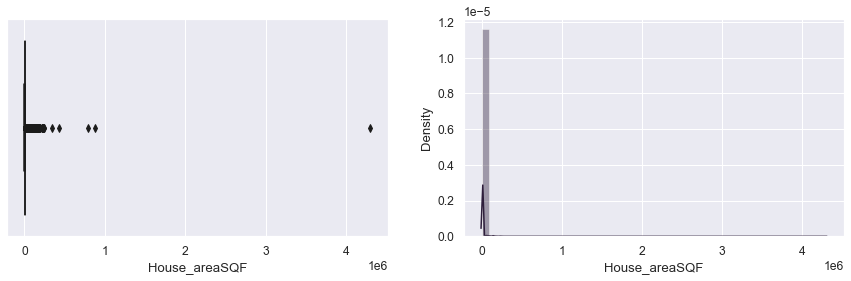

In [198]:
# see again 
fig , axis = plt.subplots(ncols = 2 , nrows = 1 , figsize = (15 , 4))
sns.boxplot(df['House_areaSQF'] , ax = axis[0])
sns.distplot(df['House_areaSQF'] , ax = axis[1])

###### still there was abnormal values 

In [199]:
df[df['House_areaSQF'] > 4*1e6]

,Posted_By,Under_Construction,approved,Number_of_Rooms,Property_type,House_areaSQF,Ready_to_move,Resale,Address,Price
24935,Owner,0,0,3,BHK,4300000.0,1,1,"New Kumaran Nagar,Chennai",43.0


In [200]:
df.drop([24935] , axis = 0 , inplace = True)

<AxesSubplot:xlabel='House_areaSQF', ylabel='Density'>

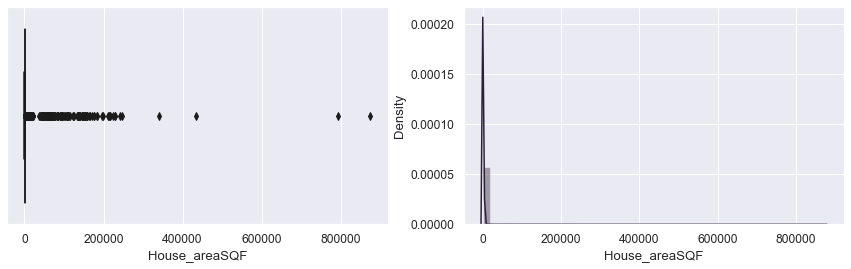

In [201]:
# see again 
fig , axis = plt.subplots(ncols = 2 , nrows = 1 , figsize = (15 , 4))
sns.boxplot(df['House_areaSQF'] , ax = axis[0])
sns.distplot(df['House_areaSQF'] , ax = axis[1])

In [202]:
df.drop(df[df['House_areaSQF'] > 200000].index , inplace = True , axis = 0)

<AxesSubplot:xlabel='House_areaSQF', ylabel='Density'>

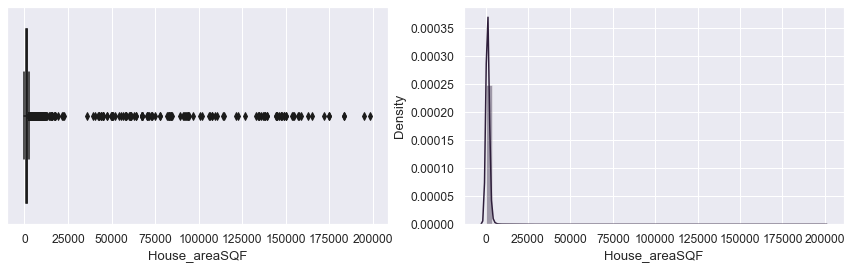

In [203]:
# and see again 
fig , axis = plt.subplots(ncols = 2 , nrows = 1 , figsize = (15 , 4))
sns.boxplot(df['House_areaSQF'] , ax = axis[0])
sns.distplot(df['House_areaSQF'] , ax = axis[1])

In [204]:
df[df['House_areaSQF'] > 25000].shape[0]
# drop them too

127

In [205]:
df.drop(df[df['House_areaSQF'] > 25000].index , inplace = True , axis = 0 )

In [206]:
df.reset_index(inplace = True , drop = True)

<AxesSubplot:xlabel='House_areaSQF', ylabel='Price'>

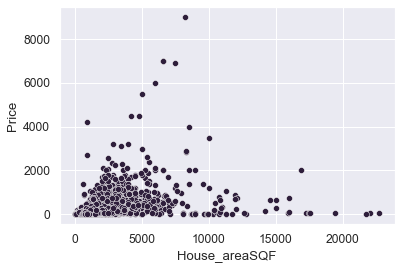

In [207]:
# now see distribution with price 
sns.scatterplot(data = df , x = 'House_areaSQF' , y = 'Price')

###### log tranform to see distribution well as (normally distributed)

<AxesSubplot:xlabel='Price', ylabel='Density'>

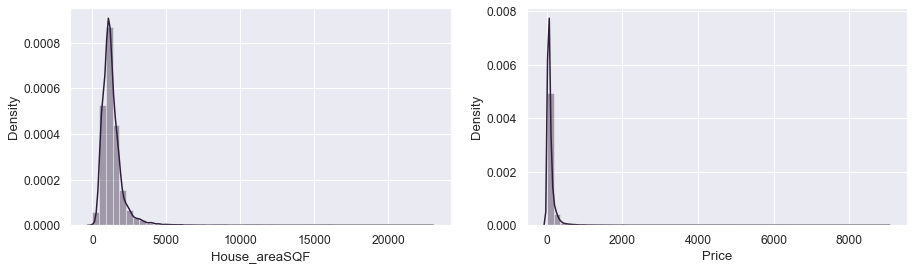

In [208]:
fig , axis = plt.subplots(ncols = 2 , nrows = 1 , figsize = (15 , 4))
sns.distplot(df['House_areaSQF'] , ax = axis[0])
sns.distplot(df['Price'] , ax = axis[1])

In [209]:
df['LogArea'] = np.log(df['House_areaSQF'])
df['LogPrice'] = np.log(df['Price'])

<AxesSubplot:xlabel='LogPrice', ylabel='Density'>

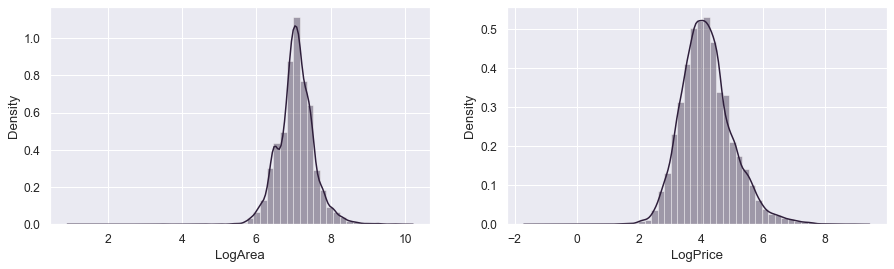

In [210]:
fig , axis = plt.subplots(ncols = 2 , nrows = 1 , figsize = (15 , 4))
sns.distplot(df['LogArea'] , ax = axis[0])
sns.distplot(df['LogPrice'] , ax = axis[1])

###### Price with -ve values !!!!

In [211]:
df.drop(df[df['LogPrice'] <= 0].index , axis = 0 , inplace = True)

<AxesSubplot:xlabel='LogArea', ylabel='LogPrice'>

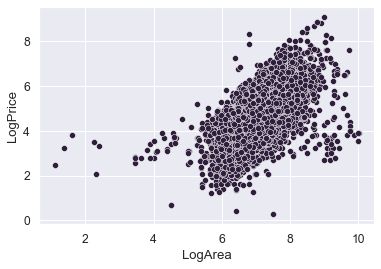

In [212]:
sns.scatterplot(data = df , x = 'LogArea' , y = 'LogPrice')

###### Still there were some values that may confuse our Model

In [213]:
df.drop(df[(df['LogArea'] < 3) & (df['LogPrice'] >= 2 )].index , inplace = True,axis =0)

<AxesSubplot:xlabel='LogArea', ylabel='LogPrice'>

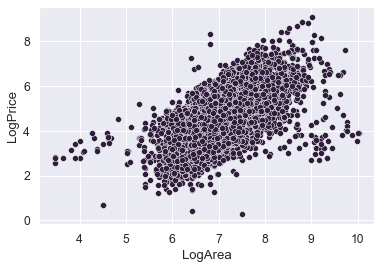

In [214]:
sns.scatterplot(data = df , x = 'LogArea' , y = 'LogPrice')

In [215]:
df.drop(df[(df['LogArea'] < 8)&(df['LogPrice'] <= 1)].index , axis = 0 , inplace = True)

<AxesSubplot:xlabel='LogArea', ylabel='LogPrice'>

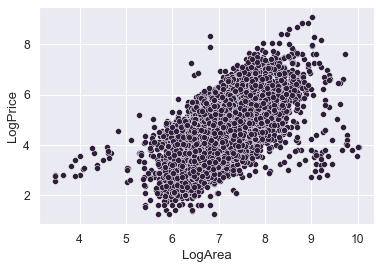

In [216]:
sns.scatterplot(data = df , x = 'LogArea' , y = 'LogPrice')

In [217]:
df.shape

(28892, 12)

##### Now get city from address 

In [218]:
df['City'] = df['Address'].apply(lambda x : x.split(',')[1].strip().lower())

In [219]:
df['City'].value_counts()

bangalore               4231
lalitpur                2938
mumbai                  1987
pune                    1963
noida                   1708
                        ... 
opp to nagarjuna sch       1
patan road                 1
nandi garden               1
vidisha                    1
lake view recidency        1
Name: City, Length: 414, dtype: int64

In [220]:
df.drop(['Address'] , axis = 1 ,inplace = True)

In [221]:
df.head(3)

,Posted_By,Under_Construction,approved,Number_of_Rooms,Property_type,House_areaSQF,Ready_to_move,Resale,Price,LogArea,LogPrice,City
0,Owner,0,0,2,BHK,1300.236407,1,1,55.0,7.170301,4.007333,bangalore
1,Dealer,0,0,2,BHK,1275.000000,1,1,51.0,7.150701,3.931826,mysore
2,Owner,0,0,2,BHK,933.159722,1,1,43.0,6.838576,3.761200,bangalore


In [222]:
df['Number_of_Rooms'].value_counts()

2     13108
3     10294
1      3522
4      1687
5       189
6        52
8        10
7        10
20        4
15        4
12        3
9         3
10        3
13        1
17        1
11        1
Name: Number_of_Rooms, dtype: int64

<AxesSubplot:xlabel='Number_of_Rooms'>

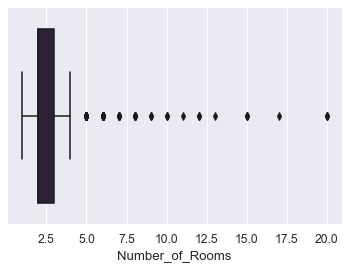

In [223]:
sns.boxplot(df['Number_of_Rooms'])

<AxesSubplot:xlabel='Number_of_Rooms', ylabel='LogPrice'>

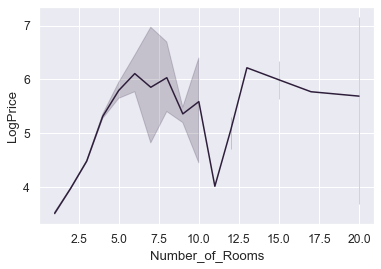

In [224]:
sns.lineplot(data = df , x = 'Number_of_Rooms' , y = 'LogPrice')

###### more than 6 rooms can confuse model so drop them 

In [225]:
df.drop(df[df['Number_of_Rooms'] > 6 ].index , inplace = True , axis = 0)

In [226]:
df.reset_index(inplace = True, drop = True)

In [227]:
df.drop(['Price' , 'House_areaSQF'] , axis = 1 , inplace = True)

In [228]:
df.head(3)

,Posted_By,Under_Construction,approved,Number_of_Rooms,Property_type,Ready_to_move,Resale,LogArea,LogPrice,City
0,Owner,0,0,2,BHK,1,1,7.170301,4.007333,bangalore
1,Dealer,0,0,2,BHK,1,1,7.150701,3.931826,mysore
2,Owner,0,0,2,BHK,1,1,6.838576,3.761200,bangalore


#### Encode our categorical Feature 

In [229]:
col_to_encd = ['Posted_By' , 'Property_type' , 'City']

In [230]:
#using Binary encoder 
encoder = BinaryEncoder()

In [231]:
df = pd.concat([df , encoder.fit_transform(df[col_to_encd])] , axis = 1)

In [232]:
df.drop(col_to_encd , inplace = True , axis = 1 )

In [233]:
df.head(3)

,Under_Construction,approved,Number_of_Rooms,Ready_to_move,Resale,LogArea,LogPrice,Posted_By_0,Posted_By_1,Property_type_0,Property_type_1,City_0,City_1,City_2,City_3,City_4,City_5,City_6,City_7,City_8
0,0,0,2,1,1,7.170301,4.007333,0,1,0,1,0,0,0,0,0,0,0,0,1
1,0,0,2,1,1,7.150701,3.931826,1,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0,2,1,1,6.838576,3.761200,0,1,0,1,0,0,0,0,0,0,0,0,1


### Split Data to Train & Test from Modeling 

In [234]:
x = df.drop(['LogPrice'] , axis = 1)
y = df['LogPrice']

In [235]:
#take 20 % as test set 
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 ,
                                                       random_state = 7 ) 

###### Scale our numerical columns to be in same scale 

In [236]:
sclr = RobustScaler()

In [237]:
x_train['LogArea'] = sclr.fit_transform(x_train[['LogArea']])

In [238]:
x_test['LogArea'] = sclr.transform(x_test[['LogArea']])

###### increase degree of Model to 4 to be more complex 

In [239]:
poly = PolynomialFeatures(degree = 4)

In [240]:
x_train = poly.fit_transform(x_train)

### Fisrt we train on Multivariable Regression 

In [241]:
linr_modl = LinearRegression()

###### train model 

In [242]:
linr_modl.fit(x_train , y_train)

LinearRegression()

###### try to make prediction on train data to get train data error 

In [243]:
ly_train_pred = linr_modl.predict(x_train)

In [244]:
mean_squared_error(y_true = y_train , y_pred = ly_train_pred , squared=False)

0.3522985729275938

###### make prediction on test to get test error and score model 

In [245]:
ly_test_pred = linr_modl.predict(poly.transform(x_test))

In [246]:
mean_squared_error(y_true = y_test , y_pred = ly_test_pred , squared = False) 

74275326.96074158

In [247]:
r2_score(y_true = y_train , y_pred = ly_train_pred)

0.819752523081313

In [248]:
r2_score(y_true = y_test , y_pred = ly_test_pred )

-7812495338609697.0

### OOPS there was high overfitting 

### Now try to use Ridge Model to avoid overfitting and regularize model 

In [249]:
model = Ridge()

In [250]:
model.fit(x_train , y_train)

Ridge()

In [251]:
y_train_pred = model.predict(x_train)

In [252]:
mean_squared_error(y_pred = y_train_pred , y_true = y_train , squared = False)

0.3542152989490129

In [253]:
y_test_pred = model.predict(poly.transform(x_test))

In [254]:
mean_squared_error(y_true = y_test , y_pred = y_test_pred , squared = False)

0.4171143618314098

##### using regularization technique we get good score some how and avoid overfitting 

In [255]:
r2_score(y_pred = y_train_pred , y_true = y_train)

0.8177858681814434

In [256]:
r2_score(y_true = y_test , y_pred = y_test_pred)

0.753616900883571

###### finally save our scaler & model 

In [257]:
joblib.dump(model , 'model.pkl')

['model.pkl']

In [258]:
joblib.dump(sclr , 'sclr.pkl')

['sclr.pkl']